# Network Analysis

## Grupo

- María Cruz 		2220279
- Pedro Guedes 	1812061
- Rodrigo Motta 	1811524
- Tatiana Reimer 	1720679

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations as comb
from networkx.algorithms import bipartite

In [2]:
name_basics = "name.basics.tsv"
nb_columns = ['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession']

nb_df = pd.read_csv(name_basics,sep='\t',header=0,usecols=nb_columns)
nb_df.dropna()
nb_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor"


In [3]:
title_akas = "title.akas.tsv"
ta_columns = ['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']
convert_dict = {'titleId': str, 'ordering': int, 'title': str, 
                'region': str, 'language': str, 'types': str, 'attributes': str, 'isOriginalTitle': str}

ta_df = pd.read_csv(title_akas,sep='\t',header=0,usecols=ta_columns,dtype=convert_dict)
ta_df = ta_df[ta_df['isOriginalTitle'] == '1']
ta_df.rename(columns={'titleId':'tconst'}, inplace=True)
ta_df.dropna()
ta_df.head()

,tconst,ordering,title,region,language,types,attributes,isOriginalTitle
6,tt0000001,7,Carmencita,\N,\N,original,\N,1
8,tt0000002,1,Le clown et ses chiens,\N,\N,original,\N,1
21,tt0000003,6,Pauvre Pierrot,\N,\N,original,\N,1
25,tt0000004,1,Un bon bock,\N,\N,original,\N,1
34,tt0000005,11,Blacksmith Scene,\N,\N,original,\N,1


In [4]:
title_basics = "title.basics.tsv"
tb_columns = ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'startYear', 'isAdult', 'endYear', 'runtimeMinutes', 'genres']
convert_dict = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 
                'startYear': str, 'isAdult': object,'endYear': str, 'runtimeMinutes': str, 'genres': object}

tb_df = pd.read_csv(title_basics,sep='\t',header=0,usecols=tb_columns,dtype=convert_dict)
tb_df.dropna()
tb_df = tb_df[~tb_df['genres'].str.contains('N', na=False)]
tb_df = tb_df[~tb_df['startYear'].str.contains("N", na=False)]
tb_df = tb_df[~tb_df['isAdult'].str.contains("N", na=False)]
tb_df = tb_df[tb_df['isAdult'].astype(int) == 0]
tb_df = tb_df[tb_df['titleType'] == "movie"]
tb_df = (tb_df.drop(columns='genres').join(tb_df['genres'].str.get_dummies(sep=',')))
tb_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,Action,Adult,...,Mystery,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,0,0,...,0,0,1,0,0,0,0,0,0,0
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,1,0,...,0,0,0,0,0,0,0,0,0,0
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,0,0,...,0,0,0,0,0,0,0,0,0,0
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,0,0,...,0,0,0,0,0,0,0,0,0,0
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
title_principals = "title.principals.tsv"
tp_columns = ['tconst', 'ordering', 'nconst', 'category', 'job', 'characters']

tp_df = pd.read_csv(title_principals,sep='\t',header=0,usecols=tp_columns)
tp_df = tp_df[tp_df['category'] == "actor"]
tp_df.drop('ordering', axis=1, inplace=True) 
tp_df.drop('category', axis=1, inplace=True) 
tp_df.drop('job', axis=1, inplace=True) 
tp_df.drop('characters', axis=1, inplace=True) 
tp_df.dropna()
tp_df.head()

,tconst,nconst
11,tt0000005,nm0443482
12,tt0000005,nm0653042
16,tt0000007,nm0179163
17,tt0000007,nm0183947
21,tt0000008,nm0653028


In [6]:
title_ratings = "title.ratings.tsv"
tr_columns = ['tconst', 'averageRating', 'numVotes']

tr_df = pd.read_csv(title_ratings,sep='\t',header=0,usecols=tr_columns)
tr_df.dropna()
tr_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1914
1,tt0000002,5.8,259
2,tt0000003,6.5,1720
3,tt0000004,5.6,172
4,tt0000005,6.2,2537


### Merge

#### title.akas + title.basics + title.ratings

In [7]:
'''
ta_tb_df = pd.merge(ta_df, tb_df, how='inner',on='tconst')
movies = pd.merge(ta_tb_df, tr_df, how='inner',on='tconst')
movies.head()
'''

,tconst,ordering,title,region,language,types,attributes,isOriginalTitle,titleType,primaryTitle,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,averageRating,numVotes
0,tt0000009,1,Miss Jerry,\N,\N,original,\N,1,movie,Miss Jerry,...,1,0,0,0,0,0,0,0,5.2,200
1,tt0000574,5,The Story of the Kelly Gang,\N,\N,original,\N,1,movie,The Story of the Kelly Gang,...,0,0,0,0,0,0,0,0,6.0,785
2,tt0000591,2,L'enfant prodigue,\N,\N,original,\N,1,movie,The Prodigal Son,...,0,0,0,0,0,0,0,0,4.0,19
3,tt0000615,1,Robbery Under Arms,\N,\N,original,\N,1,movie,Robbery Under Arms,...,0,0,0,0,0,0,0,0,4.1,23
4,tt0000630,2,Amleto,\N,\N,original,\N,1,movie,Hamlet,...,0,0,0,0,0,0,0,0,2.9,25


In [8]:
'''
actors = nb_df
actors.head()
'''

,nconst,primaryName,birthYear,deathYear,primaryProfession
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor"


In [11]:
bipartite_df = tp_df

In [12]:
G = nx.Graph()
G.add_nodes_from(bipartite_df['tconst'], bipartite=0)
G.add_nodes_from(bipartite_df['nconst'], bipartite=1)

In [13]:
G.add_edges_from(zip(bipartite_df['tconst'], bipartite_df['nconst']))

In [14]:
nx.is_bipartite(G)

True

In [15]:
G.number_of_nodes()

6074521

In [16]:
nx.is_connected(G)

False

In [17]:
left_or_top = bipartite_df['tconst']
pos = nx.bipartite_layout(G, left_or_top)

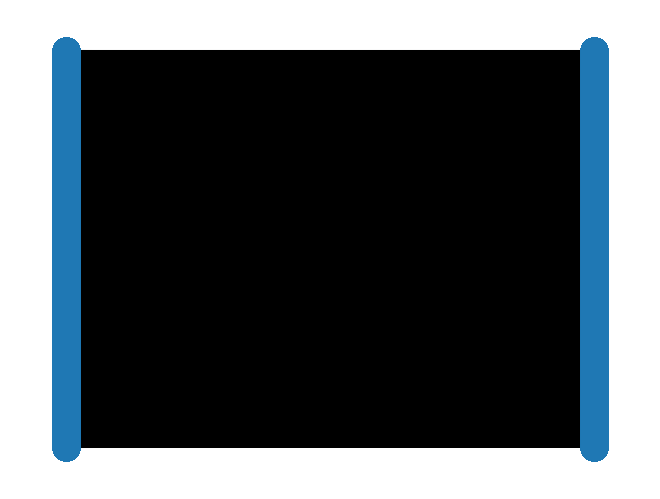

In [18]:
nx.draw(G, pos=pos, node_size=100, alpha=1, linewidths=10)
plt.show()